In [63]:
# auoreload shenanigans
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
from plotnine import (
    scale_x_discrete,
)
import polars as pl

from utils import transform_and_cmp_heights
from utils import get_percentages_and_concat
from utils import plot_percentage_bars
from utils import get_post_outliers_data
from utils import filter_bad_orders
from utils import pick_one_revision

In [65]:
pl.Config(fmt_str_lengths=50, set_tbl_rows=10)

In [66]:
partition_by_cols = ["quote_is_admin", "quote_is_freemailer"]

In [67]:
df = filter_bad_orders(get_post_outliers_data())

Data found, loading...
Height comparison 
Before: 2652877 
After:  2510458 
Diff:  -142419 (-5.37%)


In [68]:
df_quote_level = pick_one_revision(
    df, debug=False, level=["order_uuid", "quote_uuid", "line_item_uuid"]
)

Height comparison 
Before: 2510458 
After:  2510458 
Diff:  0 (0.00%)
Height comparison 
Before: 2510458 
After:  423461 
Diff:  -2086997 (-83.13%)
Height comparison 
Before: 2510458 
After:  1338957 
Diff:  -1171501 (-46.66%)


In [69]:
# Material count

MAT_COUNT_THRESH = 10

df_material_count = (
    df_quote_level.group_by("order_uuid")
    .agg(pl.count("material_subset").alias("material_count"))
    .with_columns(
        material_count=pl.when(pl.col("material_count") >= MAT_COUNT_THRESH)
        .then(MAT_COUNT_THRESH)
        .otherwise(pl.col("material_count"))
    )
)

In [70]:
# Null count (are these custom?????) custom material is a string - usually are RFQ anyways
df_ = transform_and_cmp_heights(
    df_material_count,
    df_material_count.filter(pl.col("material_count") > 0),
)

Height comparison 
Before: 423461 
After:  416325 
Diff:  -7136 (-1.69%)


In [71]:
# material_subset distribution
dfs = {
    partition_col: df_quote_level.partition_by(by=[partition_col], as_dict=True)
    for partition_col in partition_by_cols
}

df_mat_quote_type = get_percentages_and_concat(
    dfs["quote_is_freemailer"],
    count_col="material_subset",
    group_col="quote_is_freemailer",
)

df_mat_quote_internal = get_percentages_and_concat(
    dfs["quote_is_admin"],
    count_col="material_subset",
    group_col="quote_is_admin",
)

In [72]:
plot_percentage_bars(
    df_mat_quote_type,
    x="material_subset",
    y="percentage_material_subset",
    facet_col="quote_is_freemailer",
    plot_extras=[
        scale_x_discrete(
            limits=df_quote_level.filter(pl.col("material_subset").is_not_null())
            .get_column("material_subset")
            .value_counts()
            .sort("count", descending=True)
            .get_column("material_subset")[:10]
        )
    ],
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/material_freemailer.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/material_freemailer.png
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 220 rows containing missing values.


In [73]:
plot_percentage_bars(
    df_mat_quote_internal,
    x="material_subset",
    y="percentage_material_subset",
    facet_col="quote_is_admin",
    plot_extras=[
        scale_x_discrete(
            limits=df_quote_level.filter(pl.col("material_subset").is_not_null())
            .get_column("material_subset")
            .value_counts()
            .sort("count", descending=True)
            .get_column("material_subset")[:10]
        )
    ],
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/material_admin.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/material_admin.png
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 226 rows containing missing values.


In [12]:
df_quote_level_no_null_mats = transform_and_cmp_heights(
    df_quote_level, df_quote_level.filter(pl.col("order_uuid").is_in(df_["order_uuid"]))
)

Height comparison 
Before: 1338957 
After:  1316617 
Diff:  -22340 (-1.67%)


In [13]:
del dfs, df_mat_quote_type, df_mat_quote_internal

In [74]:
# finish_slug distribution (workls same wasy as mats)
dfs = {
    partition_col: df_quote_level.partition_by(by=[partition_col], as_dict=True)
    for partition_col in partition_by_cols
}

df_fin_quote_type = get_percentages_and_concat(
    dfs["quote_is_freemailer"], count_col="finish_slug", group_col="quote_is_freemailer"
)

df_fin_quote_internal = get_percentages_and_concat(
    dfs["quote_is_admin"], count_col="finish_slug", group_col="quote_is_admin"
)

In [75]:
plot_percentage_bars(
    df_fin_quote_type,
    x="finish_slug",
    y="percentage_finish_slug",
    facet_col="quote_is_freemailer",
    plot_extras=[
        scale_x_discrete(
            limits=df_quote_level.filter(pl.col("finish_slug").is_not_null())
            .get_column("finish_slug")
            .value_counts()
            .sort("count", descending=True)
            .get_column("finish_slug")[:10]
        )
    ],
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/finish_freemailer.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/finish_freemailer.png
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 40 rows containing missing values.


In [76]:
plot_percentage_bars(
    df_fin_quote_internal,
    x="finish_slug",
    y="percentage_finish_slug",
    facet_col="quote_is_admin",
    plot_extras=[
        scale_x_discrete(
            limits=df_quote_level.filter(pl.col("finish_slug").is_not_null())
            .get_column("finish_slug")
            .value_counts()
            .sort("count", descending=True)
            .get_column("finish_slug")[:10]
        )
    ],
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/finish_admin.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/finish_admin.png
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 41 rows containing missing values.


In [77]:
df_quote_level = df_quote_level.with_columns(
    li_price_multiplier_bin=pl.col("li_price_multiplier").cut(
        breaks=[x / 10 for x in range(4, 20)] + [10]
    )
)

# li_multipliers distribution (check how we use these in the demand model trianing)
dfs = {
    partition_col: df_quote_level.partition_by(by=[partition_col], as_dict=True)
    for partition_col in partition_by_cols
}

df_mult_quote_type = get_percentages_and_concat(
    dfs["quote_is_freemailer"],
    count_col="li_price_multiplier_bin",
    group_col="quote_is_freemailer",
)

df_mult_quote_internal = get_percentages_and_concat(
    dfs["quote_is_admin"],
    count_col="li_price_multiplier_bin",
    group_col="quote_is_admin",
)

In [78]:
plot_percentage_bars(
    df_mult_quote_type,
    x="li_price_multiplier_bin",
    y="percentage_li_price_multiplier_bin",
    facet_col="quote_is_freemailer",
    plot_extras=[
        scale_x_discrete(
            limits=df_quote_level.filter(
                pl.col("li_price_multiplier_bin").is_not_null()
            )
            .get_column("li_price_multiplier_bin")
            .value_counts()
            .sort("count", descending=True)
            .get_column("li_price_multiplier_bin")[:10]
        )
    ],
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/multiplier_freemailer.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/multiplier_freemailer.png
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 5 rows containing missing values.


In [79]:
plot_percentage_bars(
    df_mult_quote_internal,
    x="li_price_multiplier_bin",
    y="percentage_li_price_multiplier_bin",
    facet_col="quote_is_admin",
    plot_extras=[
        scale_x_discrete(
            limits=df_quote_level.filter(
                pl.col("li_price_multiplier_bin").is_not_null()
            )
            .get_column("li_price_multiplier_bin")
            .value_counts()
            .sort("count", descending=True)
            .get_column("li_price_multiplier_bin")[:10]
        )
    ],
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/multiplier_admin.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/multiplier_admin.png
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 6 rows containing missing values.


In [20]:
del dfs, df_mult_quote_type, df_mult_quote_internal

In [80]:
# avg time to finalize quote
dfs = {
    partition_col: df_quote_level.filter(pl.col("quote_finalized_at").is_not_null())
    .group_by("order_uuid", "quote_uuid")
    .agg(
        (pl.col("quote_finalized_at") - pl.col("quote_created"))
        .mean()
        .alias("avg_time_to_finalize_quote"),
        pl.col("quote_is_freemailer").first(),
        pl.col("quote_is_admin").first(),
    )
    .with_columns(
        avg_time_to_finalize_quote_seconds_bin=pl.col("avg_time_to_finalize_quote")
        .dt.total_seconds()
        .cut(
            [60, 60 * 10, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 3, 60 * 60 * 24 * 7],
            labels=[
                "x << 1min",
                "1min < x < 10min",
                "10min < x < 1hr",
                "1hr < x < 1day",
                "1day < x < 3days",
                "3days < x < 1week",
                "x >> 1week",
            ],
        )
    )
    .partition_by(by=[partition_col], as_dict=True)
    for partition_col in partition_by_cols
}

df_avg_to_lock_quote_type = get_percentages_and_concat(
    dfs["quote_is_freemailer"],
    count_col="avg_time_to_finalize_quote_seconds_bin",
    group_col="quote_is_freemailer",
)

df_avg_to_lock_quote_internal = get_percentages_and_concat(
    dfs["quote_is_admin"],
    count_col="avg_time_to_finalize_quote_seconds_bin",
    group_col="quote_is_admin",
)

In [81]:
plot_percentage_bars(
    df_avg_to_lock_quote_type,
    x="avg_time_to_finalize_quote_seconds_bin",
    y="percentage_avg_time_to_finalize_quote_seconds_bin",
    facet_col="quote_is_freemailer",
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/ttfinish_freemailer.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/ttfinish_freemailer.png


In [82]:
plot_percentage_bars(
    df_avg_to_lock_quote_internal,
    x="avg_time_to_finalize_quote_seconds_bin",
    y="percentage_avg_time_to_finalize_quote_seconds_bin",
    facet_col="quote_is_admin",
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/ttfinish_admin.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/ttfinish_admin.png


In [86]:
# from demand.sql in dbt rnd repo:
# -- Auto-quoted price converted to quote's currency (in cents).
# -- This value (`auto_price_amount`) is used as a line item price when not overridden by price_amount or unit_price_amount.
# -- null if RFQd (high quantities, custom materials etc) and on shipping, surcharge (like starting price), custom type lineitems

is_part = pl.col("type") == "part"
is_rfq = pl.col("unit_price_amount").is_null()

df_quote_price = (
    df_quote_level.filter(is_part, is_rfq)
    .with_columns(
        actual_li_price=pl.coalesce(
            pl.col("auto_price_amount"),
            pl.col("price_amount"),
            pl.col("unit_price_amount") * pl.col("quantity"),
        ),
    )
    .group_by("quote_uuid")
    .agg(
        (pl.sum("actual_li_price") / 100).alias("quote_actual_price"),
        pl.col("quote_is_freemailer").first(),
        pl.col("quote_is_admin").first(),
        pl.col("quote_finalized_at").first(),
        pl.col("email").first(),
    )
).filter(
    pl.col("quote_actual_price") > 0
)  # for some reason there are still nulls

dfs = {
    partition_col: df_quote_price.with_columns(
        quote_actual_price_bin=pl.col("quote_actual_price").cut(
            [200, 400, 600, 800, 1000, 2000, 4000, 8000, 16000]
        )
    ).partition_by(by=[partition_col], as_dict=True)
    for partition_col in partition_by_cols
}

df_price_quote_type = get_percentages_and_concat(
    dfs["quote_is_freemailer"],
    count_col="quote_actual_price_bin",
    group_col="quote_is_freemailer",
)

df_price_quote_internal = get_percentages_and_concat(
    dfs["quote_is_admin"],
    count_col="quote_actual_price_bin",
    group_col="quote_is_admin",
)

In [87]:
plot_percentage_bars(
    df_price_quote_type,
    x="quote_actual_price_bin",
    y="percentage_quote_actual_price_bin",
    facet_col="quote_is_freemailer",
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/price_freemailer.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/price_freemailer.png


In [88]:
plot_percentage_bars(
    df_price_quote_internal,
    x="quote_actual_price_bin",
    y="percentage_quote_actual_price_bin",
    facet_col="quote_is_admin",
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/price_admin.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/price_admin.png


In [46]:
df_quote_price.group_by("quote_is_freemailer").agg(pl.sum("quote_actual_price"))

quote_is_freemailer,quote_actual_price
bool,f64
false,4.3569e8
true,1.0173e8


In [89]:
from utils import plot_bar

# all locked and non-locked
plot_bar(
    df_quote_price.group_by("quote_is_freemailer").agg(pl.sum("quote_actual_price")),
    x="quote_is_freemailer",
    y="quote_actual_price",
    is_grouped=True,
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/price_total_freemailer.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/price_total_freemailer.png


In [90]:
plot_bar(
    df_quote_price.group_by("quote_is_admin").agg(pl.sum("quote_actual_price")),
    x="quote_is_admin",
    y="quote_actual_price",
    is_grouped=True,
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/price_total_admin.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/price_total_admin.png


In [91]:
# only locked
plot_bar(
    df_quote_price.filter(pl.col("quote_finalized_at").is_not_null())
    .group_by("quote_is_freemailer")
    .agg(pl.sum("quote_actual_price")),
    x="quote_is_freemailer",
    y="quote_actual_price",
    is_grouped=True,
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/price_total_locked_freemailer.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/price_total_locked_freemailer.png


In [92]:
# only locked
plot_bar(
    df_quote_price.filter(pl.col("quote_finalized_at").is_not_null())
    .group_by("quote_is_admin")
    .agg(pl.sum("quote_actual_price")),
    x="quote_is_admin",
    y="quote_actual_price",
    is_grouped=True,
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/price_total_locked_admin.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/price_total_locked_admin.png


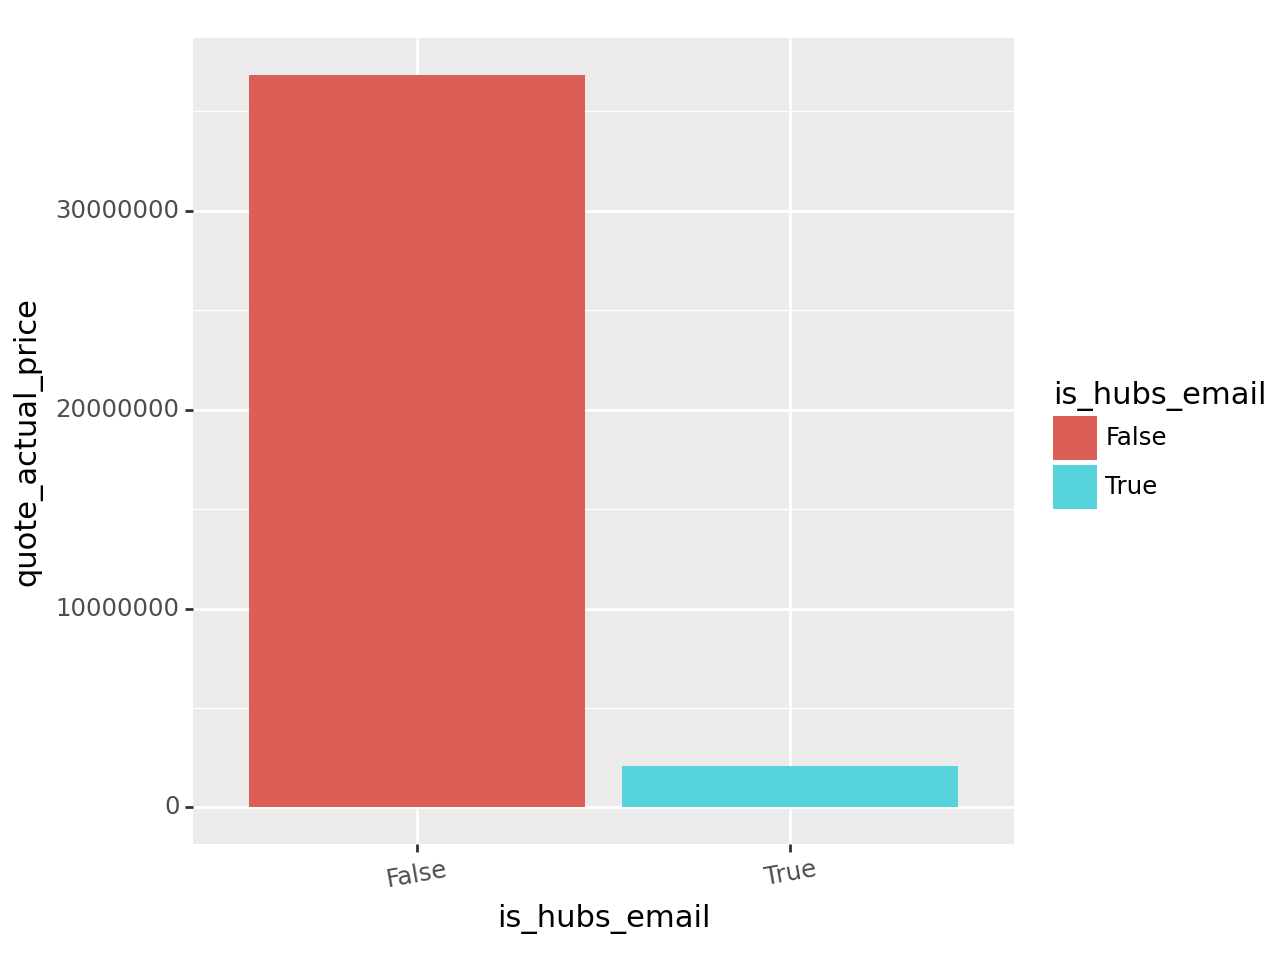

<Figure Size: (640 x 480)>

In [62]:
is_hubs_email = (
    pl.col("email").str.contains("3dhubs.com")
    | pl.col("email").str.contains("hubs.com")
    | pl.col("email").str.contains("pthubs.com")
)

df_quote_price = df_quote_price.with_columns(is_hubs_email=is_hubs_email)

# only locked
plot_bar(
    df_quote_price.filter(
        pl.col("quote_finalized_at").is_not_null(), pl.col("quote_is_admin")
    )
    .group_by("is_hubs_email")
    .agg(pl.sum("quote_actual_price")),
    x="is_hubs_email",
    y="quote_actual_price",
    is_grouped=True,
)

In [58]:
df["email"]

email
str
"""pascal.labarthe@ixblue.com"""
"""pascal.labarthe@ixblue.com"""
"""karl.perre@boreal-sub.com"""
"""Stuart.Ponder@vpgsensors.com"""
"""Stuart.Ponder@vpgsensors.com"""
…
"""finbar.allan@team-accessories.aero"""
"""finbar.allan@team-accessories.aero"""
"""finbar.allan@team-accessories.aero"""


In [101]:
dfs = {
    partition_col: df_quote_level.with_columns(
        lead_time_bin=pl.col("lead_time").cut([3, 7, 15, 30, 60])
    ).partition_by(by=[partition_col], as_dict=True)
    for partition_col in partition_by_cols
}

df_lt_quote_type = get_percentages_and_concat(
    dfs["quote_is_freemailer"],
    count_col="lead_time_bin",
    group_col="quote_is_freemailer",
)

df_lt_quote_internal = get_percentages_and_concat(
    dfs["quote_is_admin"],
    count_col="lead_time_bin",
    group_col="quote_is_admin",
)

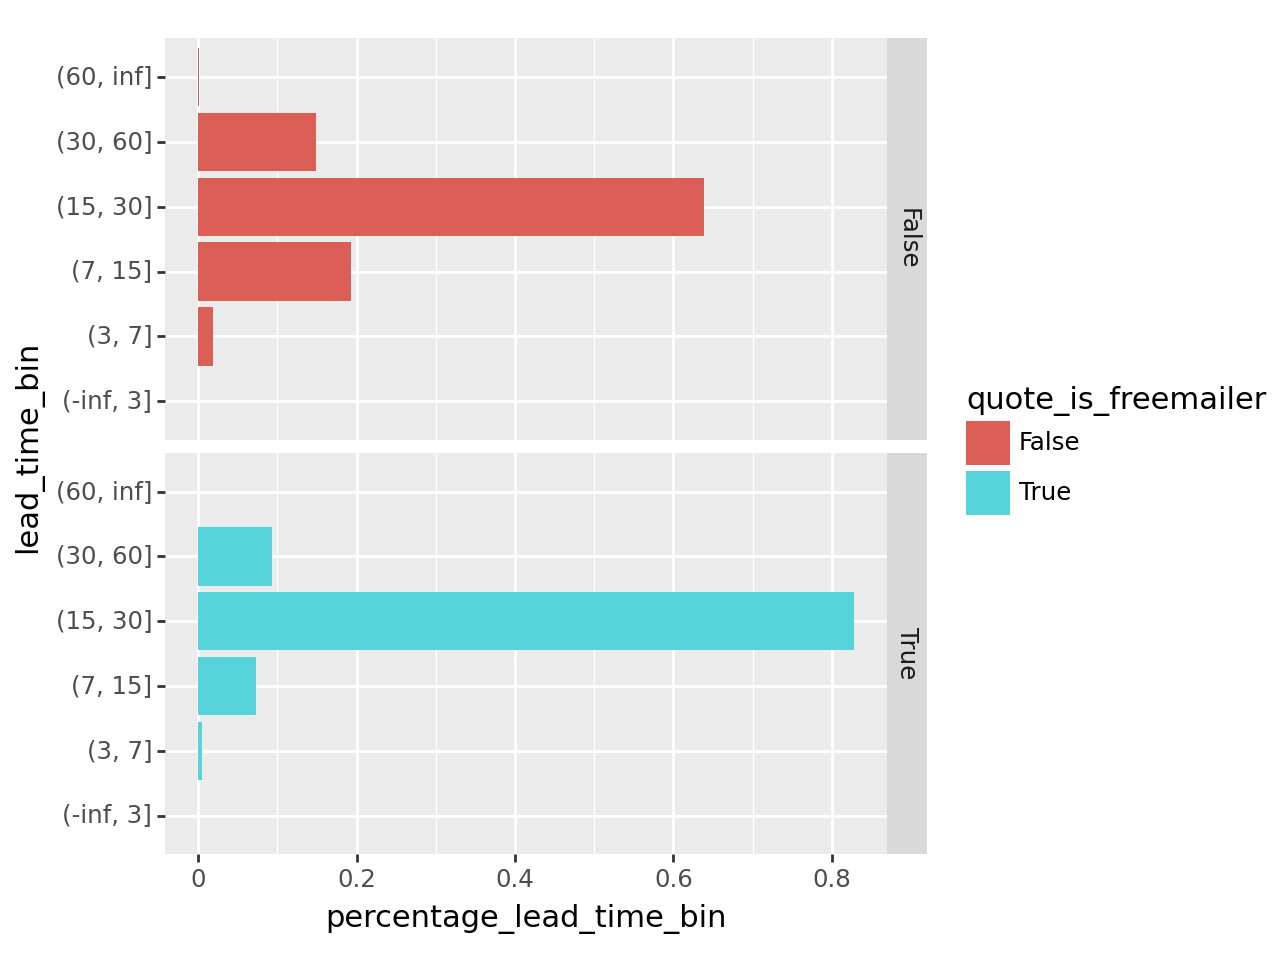

<Figure Size: (640 x 480)>

In [102]:
plot_percentage_bars(
    df_lt_quote_type,
    x="lead_time_bin",
    y="percentage_lead_time_bin",
    facet_col="quote_is_freemailer",
)

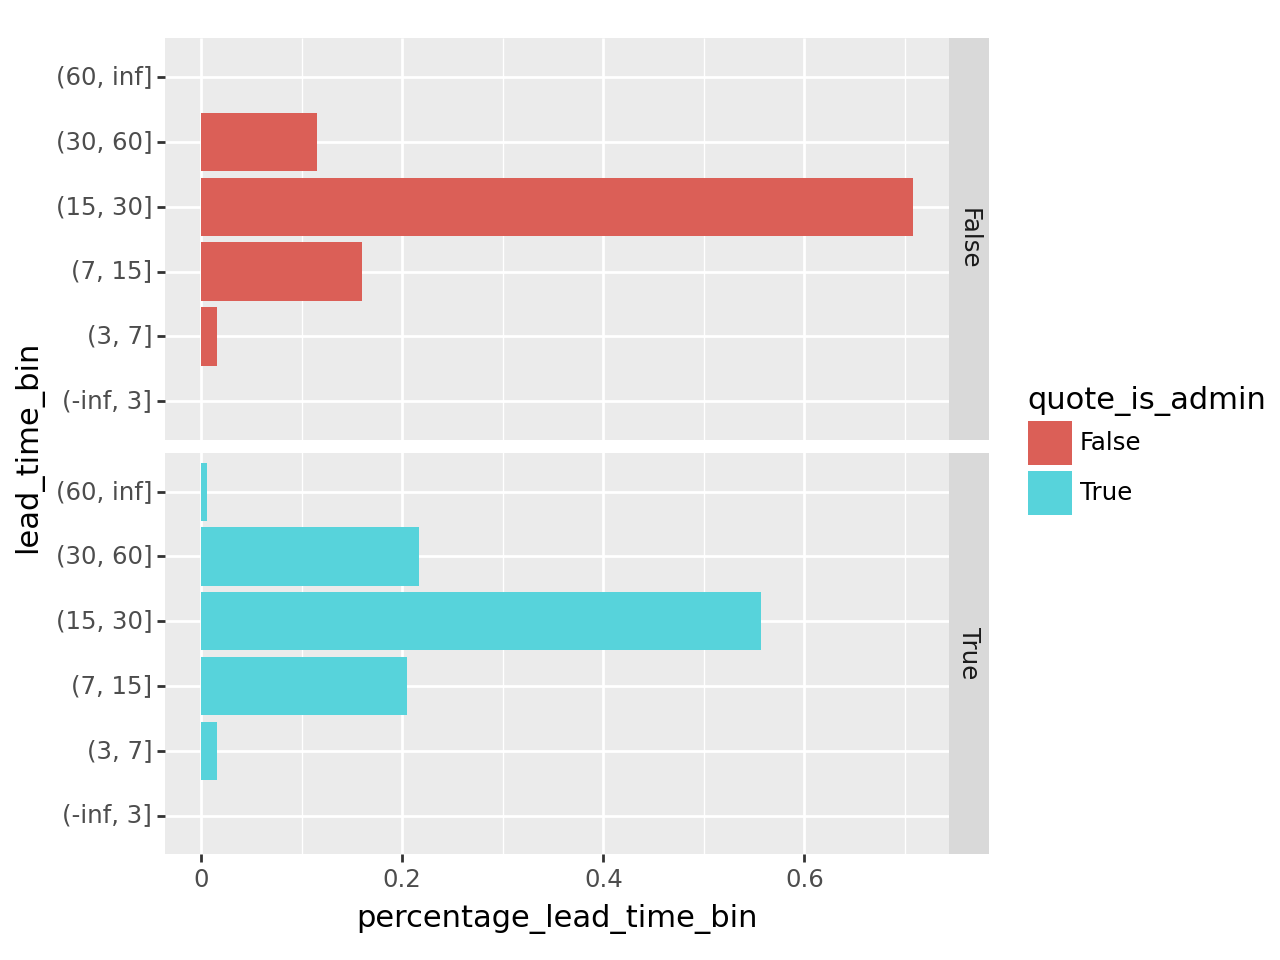

<Figure Size: (640 x 480)>

In [103]:
plot_percentage_bars(
    df_lt_quote_internal,
    x="lead_time_bin",
    y="percentage_lead_time_bin",
    facet_col="quote_is_admin",
)

In [104]:
dfs = {
    partition_col: df_quote_level.filter(is_part)
    .with_columns(
        quantity_bin=pl.col("quantity").cut(
            [1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000]
        )
    )
    .partition_by(by=[partition_col], as_dict=True)
    for partition_col in partition_by_cols
}

df_qty_quote_type = get_percentages_and_concat(
    dfs["quote_is_freemailer"],
    count_col="quantity_bin",
    group_col="quote_is_freemailer",
)

df_qty_quote_internal = get_percentages_and_concat(
    dfs["quote_is_admin"],
    count_col="quantity_bin",
    group_col="quote_is_admin",
)

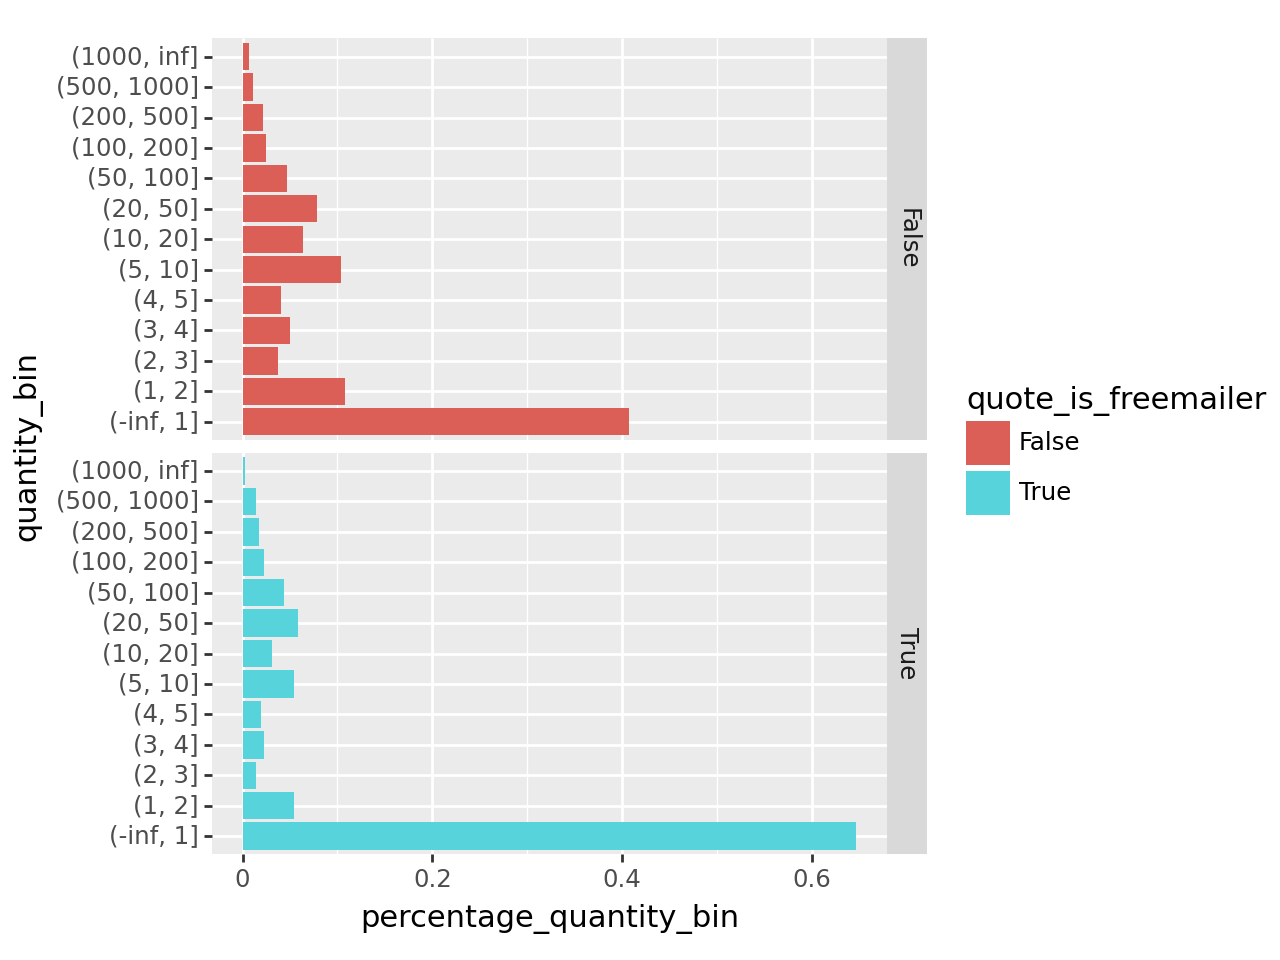

<Figure Size: (640 x 480)>

In [105]:
plot_percentage_bars(
    df_qty_quote_type,
    x="quantity_bin",
    y="percentage_quantity_bin",
    facet_col="quote_is_freemailer",
)

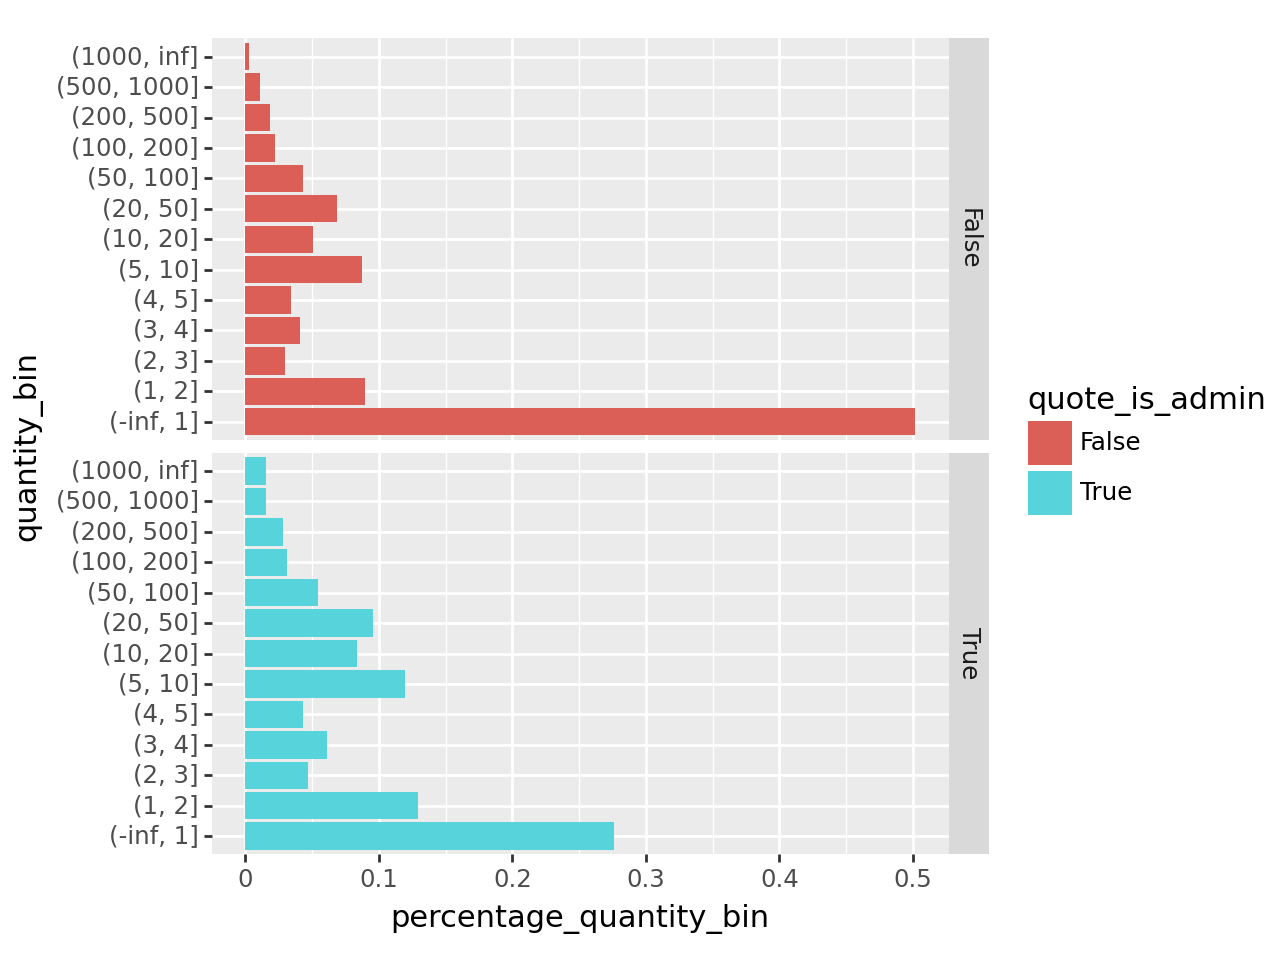

<Figure Size: (640 x 480)>

In [106]:
plot_percentage_bars(
    df_qty_quote_internal,
    x="quantity_bin",
    y="percentage_quantity_bin",
    facet_col="quote_is_admin",
)

In [95]:
[x for x in df_quote_level.columns if "created" in x]

['order_created',
 'line_item_created',
 'quote_created',
 'created_usd_rate',
 'order_created_right',
 'line_item_created_right',
 'quote_created_right',
 'created_usd_rate_right']

In [98]:
df_quote_level.sort("order_created").group_by("quote_email_provider").agg(
    pl.col("order_created").first()
).filter(pl.col("quote_email_provider") == "pthubs.com")

quote_email_provider,order_created
str,datetime[μs]
"""pthubs.com""",2023-02-24 17:44:10.474975


In [ ]:
# price elasticity diff between freemailers and non freemailers
# non freemailers have lower retention
# check revenue for freemailers vs non freemailers (more often they pull up)
# optimize model for repeat customers
# maybe remove all freemailers from demand data?